In [1]:
from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, ZuMandelbaum15Cens, ZuMandelbaum15Sats, \
                                        Leauthaud11Cens, Leauthaud11Sats, Zheng07Cens, Zheng07Sats, \
                                        NFWPhaseSpace, SubhaloPhaseSpace
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace, Tinker13Cens, Tinker13QuiescentSats, \
                                        TrivialProfile, Tinker13ActiveSats

import numpy as np
import matplotlib.pyplot as plt

from halotools.mock_observables import tpcf

from halotools.sim_manager import HaloTableCache
from halotools.sim_manager import CachedHaloCatalog


from halotools.utils import crossmatch
import time

from halotools.utils import angles_between_list_of_vectors, normalized_vectors
from halotools.utils.mcrotations import rotate_vector_collection

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

In [2]:
#from halotools_ia.ia_models.ia_model_components import CentralAlignment, RandomAlignment, RadialSatelliteAlignment, \
#                                                        HybridSatelliteAlignment, MajorAxisSatelliteAlignment, SatelliteAlignment, \
#                                                        SubhaloAlignment
#from halotools_ia.ia_models.ia_strength_models import RadialSatelliteAlignmentStrength, RadialSatelliteAlignmentStrengthAlternate
#
#from halotools_ia.ia_models.nfw_phase_space import AnisotropicNFWPhaseSpace
#from halotools_ia.correlation_functions import ed_3d, ee_3d
#from halotools_ia.correlation_functions.alignment_helpers import process_3d_alignment_args

In [7]:
from halotools.empirical_models.ia_models.ia_model_components import CentralAlignment, RandomAlignment, RadialSatelliteAlignment, SubhaloAlignment
from halotools.empirical_models.ia_models.ia_strength_models import RadialSatelliteAlignmentStrength
from halotools.mock_observables.ia_correlations import ed_3d, ee_3d
from halotools.mock_observables.ia_correlations.alignment_helpers import process_3d_alignment_args

In [8]:
# Eliminate halos with 0 for halo_axisA_x(,y,z)
def mask_bad_halocat(halocat):
    bad_mask = (halocat.halo_table["halo_axisA_x"] == 0) & (halocat.halo_table["halo_axisA_y"] == 0) & (halocat.halo_table["halo_axisA_z"] == 0)
    bad_mask = bad_mask ^ np.ones(len(bad_mask), dtype=bool)
    halocat._halo_table = halocat.halo_table[ bad_mask ]

In [9]:
cache = HaloTableCache()
for entry in cache.log: print(entry)

#halocat = CachedHaloCatalog(simname='multidark', redshift=0)
halocat = CachedHaloCatalog(simname='bolplanck', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')
mask_bad_halocat(halocat)

('bolplanck', 'rockstar', 'halotools_v0p4', '-0.0023', '/home/nvanalfen/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', '/home/nvanalfen/.astropy/cache/halotools/halo_catalogs/bolshoi/rockstar/hlist_1.00035.list.halotools_v0p4.hdf5')


In [10]:
halocat.halo_table

halo_vmax_firstacc,halo_dmvir_dt_tdyn,halo_macc,halo_scale_factor,halo_vmax_mpeak,halo_m_pe_behroozi,halo_delta_vmax_behroozi17,halo_xoff,halo_spin,halo_tidal_force,halo_scale_factor_firstacc,halo_c_to_a,halo_mvir_firstacc,halo_scale_factor_last_mm,halo_tidal_id,halo_scale_factor_mpeak,halo_pid,halo_m500c,halo_id,halo_halfmass_scale_factor,halo_upid,halo_t_by_u,halo_rvir,halo_vpeak,halo_dmvir_dt_100myr,halo_mpeak,halo_m_pe_diemer,halo_jx,halo_jy,halo_jz,halo_m2500c,halo_mvir,halo_voff,halo_axisA_z,halo_axisA_x,halo_axisA_y,halo_y,halo_b_to_a,halo_x,halo_z,halo_m200b,halo_vacc,halo_scale_factor_lastacc,halo_vmax,halo_m200c,halo_vx,halo_vy,halo_vz,halo_dmvir_dt_inst,halo_tidal_force_tdyn,halo_rs,halo_nfw_conc,halo_hostid,halo_mvir_host_halo
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32
1001.57,12810.0,200800000000000.0,1.00231,1001.57,202700000000000.0,-0.0026,0.0257357,0.02391,0.11954,1.00231,0.47559,200800000000000.0,0.28343,2812606193,1.002,-1,116580000000000.0,2811042639,0.41506,-1,0.593,1.190447,1091.38,17390.0,200800000000000.0,111800000000000.0,2536000000000000.0,-474400000000000.0,-6566000000000000.0,65777000000000.0,200800000000000.0,21.34,19.2231,59.7891,-18.8001,43.14082,0.63663,36.17984,17.96339,223780000000000.0,1001.57,1.00231,1001.57,158240000000000.0,16.1,8.51,-78.88,17390.0,0.12244,0.137953,8.629367,2811042639,200800000000000.0
895.2,13760.0,179600000000000.0,1.00231,895.2,181000000000000.0,-0.01065,0.041987,0.06297,0.50587,1.00231,0.56181,179600000000000.0,0.29862,2811077105,1.002,-1,100360000000000.0,2811055606,0.50618,-1,0.627,1.146849,969.05,7324.0,179600000000000.0,128700000000000.0,1.074e+16,4931000000000000.0,-1.185e+16,47026000000000.0,179600000000000.0,41.91,41.2062,34.6803,17.8882,49.54417,0.8397,45.36644,40.01593,204460000000000.0,895.2,1.00231,895.2,142290000000000.0,2.46,264.77,-128.08,7324.0,0.491,0.185805,6.172326,2811055606,179600000000000.0
853.83,4666.0,129800000000000.0,1.00231,853.83,149500000000000.0,0.00531,0.026461901,0.03607,0.07568,1.00231,0.66381,129800000000000.0,0.49606,2810630242,1.002,-1,87766000000000.0,2809250167,0.491,-1,0.5774,1.029343,926.37,2747.0,129800000000000.0,80320000000000.0,2133000000000000.0,-3236000000000000.0,-3111000000000000.0,39496000000000.0,129800000000000.0,23.35,-17.5268,38.9596,24.3626,13.88261,0.76149,22.02318,9.80153,141210000000000.0,853.83,1.00231,853.83,112010000000000.0,18.49,124.89,-35.19,2747.0,0.10074,0.119293995,8.628624,2809250167,129800000000000.0
777.64,4401.0,103000000000000.0,1.00231,777.64,104800000000000.0,0.00498,0.0516998,0.05031,0.09677,1.00231,0.47302,103000000000000.0,0.38469,2820592816,1.002,-1,57781000000000.0,2809483946,0.65806,-1,0.6152,0.952978,831.17,2747.0,103000000000000.0,64200000000000.0,1713000000000000.0,-1488000000000000.0,4582000000000000.0,30529000000000.0,103000000000000.0,98.45,24.7744,-10.3568,38.9949,36.67881,0.7881,12.29788,34.18085,115110000000000.0,777.64,1.00231,777.64,82069000000000.0,-281.37,-115.39,-391.28,2747.0,0.10259,0.132334,7.201309,2809483946,103000000000000.0
748.56,11480.0,99470000000000.0,1.00231,748.56,107600000000000.0,0.05989,0.0779697,0.0348,0.12465,1.00231,0.47409,99470000000000.0,0.63275,2809483946,1.002,-1,59100000000000.0,2809272603,0.63781,-1,0.67,0.941893,748.56,5218.0,99470000000000.0,70970000000000.0,1207000000000000.0,-2126000000000000.0,-2677000000000000.0,26267000000000.0,99470000000000.0,118.79,29.2183,52.7796,6.18836,26.12877,0.66155,10.66037,22.5009,108110000000000.0,748.56,1.00231,748.56,84337000000000.0,-43.87,292.95,-171.47,5218.0,0.1579,0.14077,6.691006,2809272603,99470000000000.0
793.17,-2158.0,95030000000000.

In [11]:
seed=132358712

In [12]:
cens_occ_model = Leauthaud11Cens
cens_prof_model = TrivialPhaseSpace
cens_orientation = CentralAlignment
sats_occ_model = Leauthaud11Sats
sats_prof_model1 = SubhaloPhaseSpace
prof_args1 = ("satellites", np.logspace(10.5, 15.2, 15))
#sats_orientation = RadialSatelliteAlignment
#sats_orientation = SubhaloAlignment
sats_orientation = RadialSatelliteAlignment
sats_strength = RadialSatelliteAlignmentStrength(satellite_alignment_a=0.805, satellite_alignment_gamma=-0.029)
Lbox = halocat.Lbox
sats_strength.inherit_halocat_properties(Lbox=Lbox)

model_instance = HodModelFactory(centrals_occupation = cens_occ_model(),
                                 centrals_profile = cens_prof_model(),
                                 satellites_occupation = sats_occ_model(),
                                 satellites_profile = SubhaloPhaseSpace(*prof_args1),
                                 satellites_radial_alignment_strength = sats_strength,
                                 centrals_orientation = cens_orientation(central_alignment_strength=1),
                                 satellites_orientation = sats_orientation(satellite_alignment_strength=1, halocat=halocat),
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'satellites_radial_alignment_strength',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )

#seed=None
model_instance.populate_mock(halocat,seed=seed)

In [13]:
cens_occ_model = Leauthaud11Cens
cens_prof_model = TrivialPhaseSpace
cens_orientation = CentralAlignment
sats_occ_model = Leauthaud11Sats
sats_prof_model1 = SubhaloPhaseSpace
prof_args1 = ("satellites", np.logspace(10.5, 15.2, 15))
#sats_orientation = SubhaloAlignment
sats_orientation = RadialSatelliteAlignment

model_instance_const = HodModelFactory(centrals_occupation = cens_occ_model(),
                                 centrals_profile = cens_prof_model(),
                                 satellites_occupation = sats_occ_model(),
                                 satellites_profile = SubhaloPhaseSpace(*prof_args1),
                                 centrals_orientation = cens_orientation(central_alignment_strength=1),
                                 satellites_orientation = sats_orientation(satellite_alignment_strength=0.826, halocat=halocat),
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )

#seed=None
model_instance_const.populate_mock(halocat,seed=seed)

In [14]:
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [15]:
runs = 50

halo_cen_sat_xi = np.zeros( len(rbin_centers) )
galaxy_cen_sat_xi = np.zeros( ( runs, len(rbin_centers) ) )
galaxy_cen_sat_xi_const = np.zeros( ( runs, len(rbin_centers) ) )

halo_cen_pos_sat_shape_omega = np.zeros( len(rbin_centers) )
galaxy_cen_pos_sat_shape_omega = np.zeros( ( runs,len(rbin_centers) ) )
galaxy_cen_pos_sat_shape_omega_const = np.zeros( ( runs,len(rbin_centers) ) )

halo_cen_sat_eta = np.zeros( len(rbin_centers) )
galaxy_cen_sat_eta = np.zeros( ( runs,len(rbin_centers) ) )
galaxy_cen_sat_eta_const = np.zeros( ( runs,len(rbin_centers) ) )

inds1, inds2 = crossmatch(model_instance.mock.galaxy_table['halo_id'], halocat.halo_table['halo_id'])
halo_coords = np.array( [ halocat.halo_table[inds2]["halo_x"], 
                            halocat.halo_table[inds2]["halo_y"],
                            halocat.halo_table[inds2]["halo_z"] ] ).T
halo_orientations = np.array( [ halocat.halo_table[inds2]["halo_axisA_x"], 
                            halocat.halo_table[inds2]["halo_axisA_y"],
                            halocat.halo_table[inds2]["halo_axisA_z"] ] ).T

sat_cut = model_instance.mock.galaxy_table[ model_instance.mock.galaxy_table["gal_type"] == "satellites" ]
cen_cut = model_instance.mock.galaxy_table[ model_instance.mock.galaxy_table["gal_type"] == "centrals" ]
sat_cut_const = model_instance_const.mock.galaxy_table[ model_instance_const.mock.galaxy_table["gal_type"] == "satellites" ]
cen_cut_const = model_instance_const.mock.galaxy_table[ model_instance_const.mock.galaxy_table["gal_type"] == "centrals" ]

# Halo sats
inds1, inds2 = crossmatch(sat_cut['halo_id'], halocat.halo_table['halo_id'])
halo_coords_sat = np.array( [ halocat.halo_table[inds2]['halo_x'],
                            halocat.halo_table[inds2]['halo_y'],
                            halocat.halo_table[inds2]['halo_z'] ] ).T
halo_orientations_sat = np.array( [ halocat.halo_table[inds2]['halo_axisA_x'],
                                halocat.halo_table[inds2]['halo_axisA_y'],
                                halocat.halo_table[inds2]['halo_axisA_z'] ] ).T


# Get central halo info
inds1, inds2 = crossmatch(cen_cut['halo_id'], halocat.halo_table['halo_id'])
halo_coords_cen = np.array( [ halocat.halo_table[inds2]['halo_x'],
                            halocat.halo_table[inds2]['halo_y'],
                            halocat.halo_table[inds2]['halo_z'] ] ).T
halo_orientations_cen = np.array( [ halocat.halo_table[inds2]['halo_axisA_x'],
                                halocat.halo_table[inds2]['halo_axisA_y'],
                                halocat.halo_table[inds2]['halo_axisA_z'] ] ).T

halo_cen_sat_xi = tpcf( halo_coords_sat, rbins, halo_coords_cen, period=halocat.Lbox )[1]
halo_cen_pos_sat_shape_omega = ed_3d( halo_coords_sat, halo_orientations_sat, halo_coords_cen, rbins, period=halocat.Lbox )
halo_cen_sat_eta = ee_3d( halo_coords_sat, halo_orientations_sat, halo_coords_cen, halo_orientations_cen, rbins, period=halocat.Lbox )

for i in range(runs):
    print(i)
    model_instance.mock.populate(seed=seed)
    model_instance_const.mock.populate(seed=seed)
    
    sat_cut = model_instance.mock.galaxy_table[ model_instance.mock.galaxy_table["gal_type"] == "satellites" ]
    cen_cut = model_instance.mock.galaxy_table[ model_instance.mock.galaxy_table["gal_type"] == "centrals" ]
    sat_cut_const = model_instance_const.mock.galaxy_table[ model_instance_const.mock.galaxy_table["gal_type"] == "satellites" ]
    cen_cut_const = model_instance_const.mock.galaxy_table[ model_instance_const.mock.galaxy_table["gal_type"] == "centrals" ]
    
    # Rad. Dep. Model
    galaxy_coords = np.array( [ model_instance.mock.galaxy_table["x"], 
                                    model_instance.mock.galaxy_table["y"],
                                    model_instance.mock.galaxy_table["z"] ] ).T
    galaxy_orientations = np.array( [ model_instance.mock.galaxy_table["galaxy_axisA_x"], 
                                    model_instance.mock.galaxy_table["galaxy_axisA_y"],
                                    model_instance.mock.galaxy_table["galaxy_axisA_z"] ] ).T

    galaxy_coords_sat = np.array( [ sat_cut['x'],
                                    sat_cut['y'],
                                    sat_cut['z'] ] ).T
    galaxy_orientations_sat = np.array( [ sat_cut['galaxy_axisA_x'],
                                        sat_cut['galaxy_axisA_y'],
                                        sat_cut['galaxy_axisA_z'] ] ).T

    galaxy_coords_cen = np.array( [ cen_cut['x'],
                                    cen_cut['y'],
                                    cen_cut['z'] ] ).T
    galaxy_orientations_cen = np.array( [ cen_cut['galaxy_axisA_x'],
                                        cen_cut['galaxy_axisA_y'],
                                        cen_cut['galaxy_axisA_z'] ] ).T

    # Now for constant model
    galaxy_coords_const = np.array( [ model_instance_const.mock.galaxy_table["x"], 
                                    model_instance_const.mock.galaxy_table["y"],
                                    model_instance_const.mock.galaxy_table["z"] ] ).T
    galaxy_orientations_const = np.array( [ model_instance_const.mock.galaxy_table["galaxy_axisA_x"], 
                                    model_instance_const.mock.galaxy_table["galaxy_axisA_y"],
                                    model_instance_const.mock.galaxy_table["galaxy_axisA_z"] ] ).T

    galaxy_coords_sat_const = np.array( [ sat_cut_const['x'],
                                    sat_cut_const['y'],
                                    sat_cut_const['z'] ] ).T
    galaxy_orientations_sat_const = np.array( [ sat_cut_const['galaxy_axisA_x'],
                                        sat_cut_const['galaxy_axisA_y'],
                                        sat_cut_const['galaxy_axisA_z'] ] ).T

    galaxy_coords_cen_const = np.array( [ cen_cut_const['x'],
                                    cen_cut_const['y'],
                                    cen_cut_const['z'] ] ).T
    galaxy_orientations_cen_const = np.array( [ cen_cut_const['galaxy_axisA_x'],
                                        cen_cut_const['galaxy_axisA_y'],
                                        cen_cut_const['galaxy_axisA_z'] ] ).T
    
    
    # Correlation Functions
    # Xi
    galaxy_cen_sat_xi[i,:] = tpcf( galaxy_coords_sat, rbins, galaxy_coords_cen, period=halocat.Lbox )[1]
    galaxy_cen_sat_xi_const[i,:] = tpcf( galaxy_coords_sat_const, rbins, galaxy_coords_cen_const, period=halocat.Lbox )[1]
    
    # Omega
    galaxy_cen_pos_sat_shape_omega[i,:] = ed_3d( galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, rbins, period=halocat.Lbox )
    galaxy_cen_pos_sat_shape_omega_const[i,:] = ed_3d( galaxy_coords_sat_const, galaxy_orientations_sat_const, galaxy_coords_cen_const, rbins, period=halocat.Lbox )
    
    # Eta
    galaxy_cen_sat_eta[i,:] = ee_3d( galaxy_coords_sat, galaxy_orientations_sat, galaxy_coords_cen, galaxy_orientations_cen, rbins, period=halocat.Lbox )
    galaxy_cen_sat_eta_const[i,:] = ee_3d( galaxy_coords_sat_const, galaxy_orientations_sat_const, galaxy_coords_cen_const, galaxy_orientations_cen_const, rbins, period=halocat.Lbox )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [16]:
galaxy_xi_mean = np.mean( galaxy_cen_sat_xi, axis=0 )
galaxy_xi_std = np.std( galaxy_cen_sat_xi, axis=0 )
galaxy_xi_const_mean = np.mean( galaxy_cen_sat_xi_const, axis=0 )
galaxy_xi_const_std = np.std( galaxy_cen_sat_xi_const, axis=0 )

galaxy_omega_mean = np.mean( galaxy_cen_pos_sat_shape_omega, axis=0 )
galaxy_omega_std = np.std( galaxy_cen_pos_sat_shape_omega, axis=0 )
galaxy_omega_const_mean = np.mean( galaxy_cen_pos_sat_shape_omega_const, axis=0 )
galaxy_omega_const_std = np.std( galaxy_cen_pos_sat_shape_omega_const, axis=0 )

galaxy_eta_mean = np.mean( galaxy_cen_sat_eta, axis=0 )
galaxy_eta_std = np.std( galaxy_cen_sat_eta, axis=0 )
galaxy_eta_const_mean = np.mean( galaxy_cen_sat_eta_const, axis=0 )
galaxy_eta_const_std = np.std( galaxy_cen_sat_eta_const, axis=0 )

In [17]:
np.save( os.path.join("three_panel_data", "halo_cen_sat_xi.npy"), halo_cen_sat_xi)
np.save( os.path.join("three_panel_data", "halo_cen_pos_sat_shape_omega.npy"), halo_cen_pos_sat_shape_omega)
np.save( os.path.join("three_panel_data", "halo_cen_sat_eta.npy"), halo_cen_sat_eta)

np.save( os.path.join("three_panel_data", "galaxy_xi_mean.npy" ), galaxy_xi_mean )
np.save( os.path.join("three_panel_data", "galaxy_xi_std.npy" ), galaxy_xi_std )
np.save( os.path.join("three_panel_data", "galaxy_xi_const_mean.npy" ), galaxy_xi_const_mean )
np.save( os.path.join("three_panel_data", "galaxy_xi_const_std.npy" ), galaxy_xi_const_std )
np.save( os.path.join("three_panel_data", "galaxy_omega_mean.npy" ), galaxy_omega_mean )
np.save( os.path.join("three_panel_data", "galaxy_omega_std.npy" ), galaxy_omega_std )
np.save( os.path.join("three_panel_data", "galaxy_omega_const_mean.npy" ), galaxy_omega_const_mean )
np.save( os.path.join("three_panel_data", "galaxy_omega_const_std.npy" ), galaxy_omega_const_std )
np.save( os.path.join("three_panel_data", "galaxy_eta_mean.npy" ), galaxy_eta_mean )
np.save( os.path.join("three_panel_data", "galaxy_eta_std.npy" ), galaxy_eta_std )
np.save( os.path.join("three_panel_data", "galaxy_eta_const_mean.npy" ), galaxy_eta_const_mean )
np.save( os.path.join("three_panel_data", "galaxy_eta_const_std.npy" ), galaxy_eta_const_std )

In [18]:
halo_cen_sat_xi = np.load( os.path.join("three_panel_data", "halo_cen_sat_xi.npy") )
halo_cen_pos_sat_shape_omega = np.load( os.path.join("three_panel_data", "halo_cen_pos_sat_shape_omega.npy") )
halo_cen_sat_eta = np.load( os.path.join("three_panel_data", "halo_cen_sat_eta.npy") )

galaxy_xi_mean = np.load( os.path.join( "three_panel_data", "galaxy_xi_mean.npy" ) )
galaxy_xi_std = np.load( os.path.join( "three_panel_data", "galaxy_xi_std.npy" ) )
galaxy_xi_const_mean = np.load( os.path.join( "three_panel_data", "galaxy_xi_const_mean.npy" ) )
galaxy_xi_const_std = np.load( os.path.join( "three_panel_data", "galaxy_xi_const_std.npy" ) )
galaxy_omega_mean = np.load( os.path.join( "three_panel_data", "galaxy_omega_mean.npy" ) )
galaxy_omega_std = np.load( os.path.join( "three_panel_data", "galaxy_omega_std.npy" ) )
galaxy_omega_const_mean = np.load( os.path.join( "three_panel_data", "galaxy_omega_const_mean.npy" ) )
galaxy_omega_const_std = np.load( os.path.join( "three_panel_data", "galaxy_omega_const_std.npy" ) )
galaxy_eta_mean = np.load( os.path.join( "three_panel_data", "galaxy_eta_mean.npy" ) )
galaxy_eta_std = np.load( os.path.join( "three_panel_data", "galaxy_eta_std.npy" ) )
galaxy_eta_const_mean = np.load( os.path.join( "three_panel_data", "galaxy_eta_const_mean.npy" ) )
galaxy_eta_const_std = np.load( os.path.join( "three_panel_data", "galaxy_eta_const_std.npy" ) )

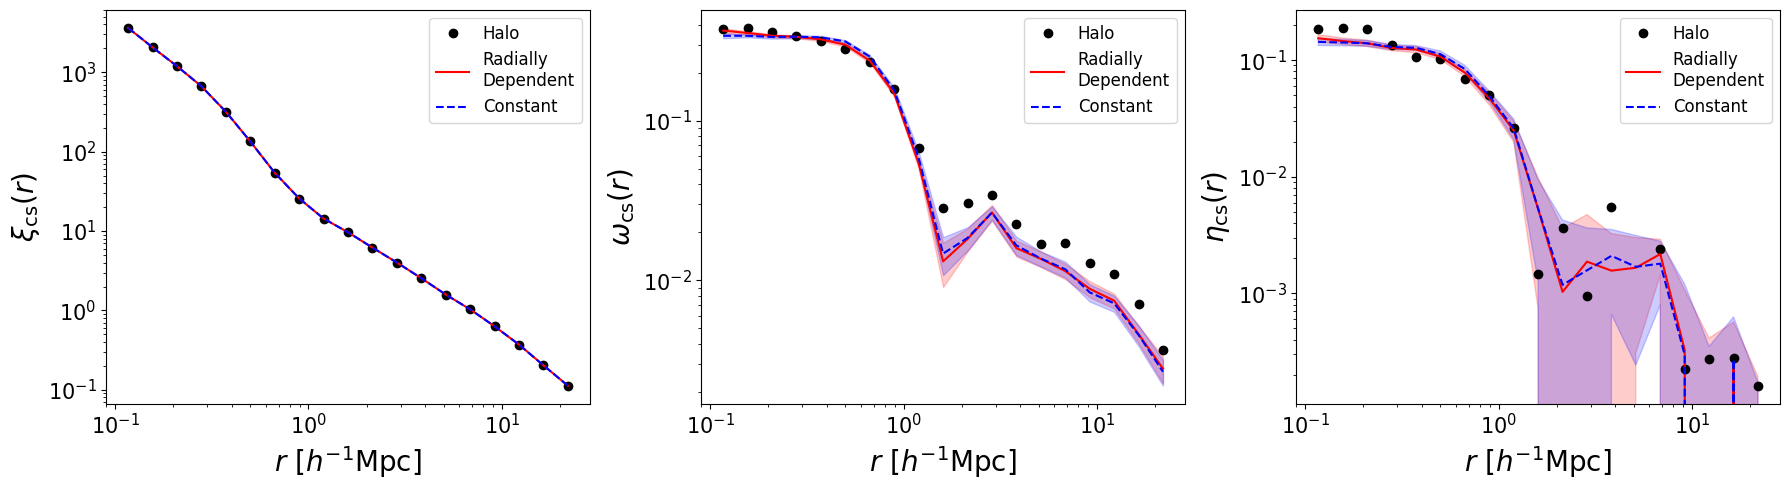

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))
plt.subplots_adjust(wspace=0.5)
#plt.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax3.tick_params(labelsize=15)

# Xi
ax1.plot( rbin_centers, halo_cen_sat_xi, "o", color="k", label="Halo" )
ax1.plot( rbin_centers, galaxy_xi_mean, "-", color="red", label="Radially\nDependent")
ax1.plot( rbin_centers, galaxy_xi_const_mean, "--", color="blue", label="Constant" )

#ax1.set_title("Position-Position Correlation Functions", fontsize=15)
ax1.set_xlabel(r'$r~[h^{-1}\rm Mpc]$', fontsize=20)
ax1.set_ylabel(r'$\xi_{\rm cs}(r)$', fontsize=20)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend(fontsize=12)

# Omega
ax2.plot( rbin_centers, halo_cen_pos_sat_shape_omega, "o", color="k", label="Halo" )
ax2.plot( rbin_centers, galaxy_omega_mean, "-", color="red", label="Radially\nDependent")
ax2.plot( rbin_centers, galaxy_omega_const_mean, "--", color="blue", label="Constant" )

ax2.fill_between( rbin_centers, galaxy_omega_mean+galaxy_omega_std, galaxy_omega_mean-galaxy_omega_std, color="red", alpha=0.2)
ax2.fill_between( rbin_centers, galaxy_omega_const_mean+galaxy_omega_const_std, galaxy_omega_const_mean-galaxy_omega_const_std, color="blue", alpha=0.2)

#ax2.set_title("Position-Shape Correlation Functions", fontsize=15)
ax2.set_xlabel(r'$r~[h^{-1}\rm Mpc]$', fontsize=20)
ax2.set_ylabel(r'$\omega_{\rm cs}(r)$', fontsize=20)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend(fontsize=12)


#Eta
ax3.plot( rbin_centers, halo_cen_sat_eta, "o", color="k", label="Halo" )
ax3.plot( rbin_centers, galaxy_eta_mean, "-", color="red", label="Radially\nDependent")
ax3.plot( rbin_centers, galaxy_eta_const_mean, "--", color="blue", label="Constant" )

ax3.fill_between( rbin_centers, galaxy_eta_mean+galaxy_eta_std, galaxy_eta_mean-galaxy_eta_std, color="red", alpha=0.2)
ax3.fill_between( rbin_centers, galaxy_eta_const_mean+galaxy_eta_const_std, galaxy_eta_const_mean-galaxy_eta_const_std, color="blue", alpha=0.2)

#ax3.set_title("Shape-Shape Correlation Functions", fontsize=15)
ax3.set_xlabel(r'$r~[h^{-1}\rm Mpc]$', fontsize=20)
ax3.set_ylabel(r'$\eta_{\rm cs}(r)$', fontsize=20)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.legend(fontsize=12)

plt.tight_layout()


plt.savefig("three_panel_correlation_cen_sat_with_error.pdf", dpi=500, bbox_inches="tight")

In [21]:
plt.xticks?

Signature: plt.xticks(ticks=None, labels=None, *, minor=False, **kwargs)
Docstring:
Get or set the current tick locations and labels of the x-axis.

Pass no arguments to return the current values without modifying them.

Parameters
----------
ticks : array-like, optional
    The list of xtick locations.  Passing an empty list removes all xticks.
labels : array-like, optional
    The labels to place at the given *ticks* locations.  This argument can
    only be passed if *ticks* is passed as well.
minor : bool, default: False
    If ``False``, get/set the major ticks/labels; if ``True``, the minor
    ticks/labels.
**kwargs
    `.Text` properties can be used to control the appearance of the labels.

Returns
-------
locs
    The list of xtick locations.
labels
    The list of xlabel `.Text` objects.

Notes
-----
Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
equivalent of calling `~.Axes.get_xticks` and `~.Axes.get_xticklabels` on
the current axes.
Calling this

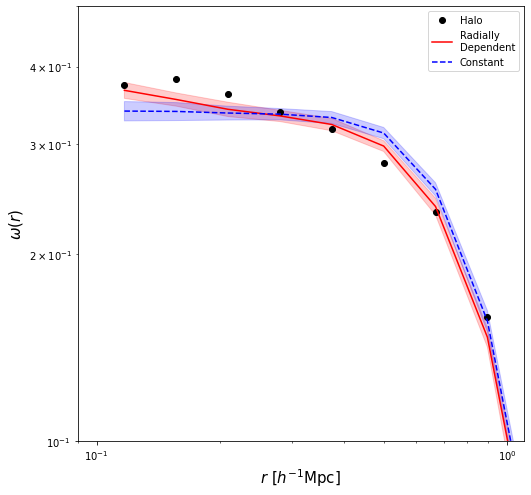

In [39]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Omega
ax.plot( rbin_centers, halo_cen_pos_sat_shape_omega, "o", color="k", label="Halo" )
ax.plot( rbin_centers, galaxy_omega_mean, "-", color="red", label="Radially\nDependent")
ax.plot( rbin_centers, galaxy_omega_const_mean, "--", color="blue", label="Constant" )

ax.fill_between( rbin_centers, galaxy_omega_mean+galaxy_omega_std, galaxy_omega_mean-galaxy_omega_std, color="red", alpha=0.2)
ax.fill_between( rbin_centers, galaxy_omega_const_mean+galaxy_omega_const_std, galaxy_omega_const_mean-galaxy_omega_const_std, color="blue", alpha=0.2)

#ax2.set_title("Position-Shape Correlation Functions", fontsize=15)
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$', fontsize=15)
ax.set_ylabel(r'$\omega(r)$', fontsize=15)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([0,1.1])
ax.set_ylim([0.1,0.5])
ax.legend()

In [13]:
split = 9

In [14]:
print("Percent Difference: Xi")
print("Radially Dependent:\t", np.mean( abs( galaxy_xi_mean - halo_cen_sat_xi )/halo_cen_sat_xi ) )
print("Constant:\t\t", np.mean( abs( galaxy_xi_const_mean - halo_cen_sat_xi )/halo_cen_sat_xi ) )
print("\n")

print("Percent Difference: Omega")
print("Radially Dependent:\t", np.mean( abs( galaxy_omega_mean - halo_cen_pos_sat_shape_omega )/halo_cen_pos_sat_shape_omega ) )
print("Constant:\t\t", np.mean( abs( galaxy_omega_const_mean - halo_cen_pos_sat_shape_omega )/halo_cen_pos_sat_shape_omega ) )
print("\n")

print("Percent Difference: Eta")
print("Radially Dependent:\t", np.mean( abs( galaxy_eta_mean - halo_cen_sat_eta )/halo_cen_sat_eta ) )
print("Constant:\t\t", np.mean( abs( galaxy_eta_const_mean - halo_cen_sat_eta )/halo_cen_sat_eta ) )
print("\n")

Percent Difference: Xi
Radially Dependent:	 0.0014773277465561412
Constant:		 0.0014773277465561412


Percent Difference: Omega
Radially Dependent:	 0.19274508521483405
Constant:		 0.19843293186049307


Percent Difference: Eta
Radially Dependent:	 0.09990939464576862
Constant:		 0.24165520618395833




In [15]:
print("Percent Difference (1H): Xi")
print("Radially Dependent:\t", np.mean( abs( galaxy_xi_mean[:split] - halo_cen_sat_xi[:split] )/halo_cen_sat_xi[:split] ) )
print("Constant:\t\t", np.mean( abs( galaxy_xi_const_mean[:split] - halo_cen_sat_xi[:split] )/halo_cen_sat_xi[:split] ) )
print("\n")

print("Percent Difference (1H): Omega")
print("Radially Dependent:\t", np.mean( abs( galaxy_omega_mean[:split] - halo_cen_pos_sat_shape_omega[:split] )/halo_cen_pos_sat_shape_omega[:split] ) )
print("Constant:\t\t", np.mean( abs( galaxy_omega_const_mean[:split] - halo_cen_pos_sat_shape_omega[:split] )/halo_cen_pos_sat_shape_omega[:split] ) )
print("\n")

print("Percent Difference (1H): Eta")
print("Radially Dependent:\t", np.mean( abs( galaxy_eta_mean[:split] - halo_cen_sat_eta[:split] )/halo_cen_sat_eta[:split] ) )
print("Constant:\t\t", np.mean( abs( galaxy_eta_const_mean[:split] - halo_cen_sat_eta[:split] )/halo_cen_sat_eta[:split] ) )
print("\n")

Percent Difference (1H): Xi
Radially Dependent:	 0.0017692179201453983
Constant:		 0.0017692179201453983


Percent Difference (1H): Omega
Radially Dependent:	 0.05852518719072491
Constant:		 0.07644856114378415


Percent Difference (1H): Eta
Radially Dependent:	 0.1306625907103749
Constant:		 0.15172533420383083




In [16]:
print("Percent Difference (2H): Xi")
print("Radially Dependent:\t", np.mean( abs( galaxy_xi_mean[split:] - halo_cen_sat_xi[split:] )/halo_cen_sat_xi[split:] ) )
print("Constant:\t\t", np.mean( abs( galaxy_xi_const_mean[split:] - halo_cen_sat_xi[split:] )/halo_cen_sat_xi[split:] ) )
print("\n")

print("Percent Difference (2H): Omega")
print("Radially Dependent:\t", np.mean( abs( galaxy_omega_mean[split:] - halo_cen_pos_sat_shape_omega[split:] )/halo_cen_pos_sat_shape_omega[split:] ) )
print("Constant:\t\t", np.mean( abs( galaxy_omega_const_mean[split:] - halo_cen_pos_sat_shape_omega[split:] )/halo_cen_pos_sat_shape_omega[split:] ) )
print("\n")

print("Percent Difference (2H): Eta")
print("Radially Dependent:\t", np.mean( abs( galaxy_eta_mean[split:] - halo_cen_sat_eta[split:] )/halo_cen_sat_eta[split:] ) )
print("Constant:\t\t", np.mean( abs( galaxy_eta_const_mean[split:] - halo_cen_sat_eta[split:] )/halo_cen_sat_eta[split:] ) )
print("\n")

Percent Difference (2H): Xi
Radially Dependent:	 0.0012146265903258103
Constant:		 0.0012146265903258103


Percent Difference (2H): Omega
Radially Dependent:	 0.31354299343653225
Constant:		 0.30821886550553107


Percent Difference (2H): Eta
Radially Dependent:	 0.07223151818762297
Constant:		 0.3225920909660732




### $\chi^2_{dof}$

In [40]:
def simple_chi_sq_dof(expected, observed, error, variables=0):
    return np.sum( (expected-observed)**2 / error**2 ) / ( len(expected) - variables )

def chi_sq_dof(expected, observed, inv_cov, variables=0):
    diff = expected - observed
    return 0.5 * ( np.dot( diff, np.dot( inv_cov, diff ) ) / ( len(expected) - variables ) )

In [53]:
omega_cov = np.cov(galaxy_cen_pos_sat_shape_omega.T)
omega_const_cov = np.cov(galaxy_cen_pos_sat_shape_omega_const.T)
eta_cov = np.cov(galaxy_cen_sat_eta.T)
eta_const_cov = np.cov(galaxy_cen_sat_eta_const.T)

omega_inv = np.linalg.inv(omega_cov)
omega_inv_front = omega_inv[:split,:split]
omega_inv_back = omega_inv[split:,split:]

omega_const_inv = np.linalg.inv(omega_const_cov)
omega_const_inv_front = omega_const_inv[:split,:split]
omega_const_inv_back = omega_const_inv[split:,split:]

eta_inv = np.linalg.inv(eta_cov)
eta_inv_front = eta_inv[:split,:split]
eta_inv_back = eta_inv[split:,split:]

eta_const_inv = np.linalg.inv(eta_const_cov)
eta_const_inv_front = eta_const_inv[:split,:split]
eta_const_inv_back = eta_const_inv[split:,split:]

In [30]:
print("Omega")
print("Radially Dependent:\t", simple_chi_sq_dof( halo_cen_pos_sat_shape_omega, galaxy_omega_mean, galaxy_omega_std, variables=2 ) )
print("Constant:\t\t", simple_chi_sq_dof( halo_cen_pos_sat_shape_omega, galaxy_omega_const_mean, galaxy_omega_const_std, variables=1 ) )
print("\n")

print("Eta")
print("Radially Dependent:\t", simple_chi_sq_dof( halo_cen_sat_eta, galaxy_eta_mean, galaxy_eta_std, variables=2 ) )
print("Constant:\t\t", simple_chi_sq_dof( halo_cen_sat_eta, galaxy_eta_const_mean, galaxy_eta_const_std, variables=1 ) )
print("\n")

Omega
Radially Dependent:	 10.066368418739595
Constant:		 12.390558066743218


Eta
Radially Dependent:	 4.730311445788219
Constant:		 6.041958176022345




In [31]:
print("Omega (1H)")
print("Radially Dependent:\t", simple_chi_sq_dof( halo_cen_pos_sat_shape_omega[:split], galaxy_omega_mean[:split], galaxy_omega_std[:split], variables=2 ) )
print("Constant:\t\t", simple_chi_sq_dof( halo_cen_pos_sat_shape_omega[:split], galaxy_omega_const_mean[:split], galaxy_omega_const_std[:split], variables=1 ) )
print("\n")

print("Eta (1H)")
print("Radially Dependent:\t", simple_chi_sq_dof( halo_cen_sat_eta[:split], galaxy_eta_mean[:split], galaxy_eta_std[:split], variables=2 ) )
print("Constant:\t\t", simple_chi_sq_dof( halo_cen_sat_eta[:split], galaxy_eta_const_mean[:split], galaxy_eta_const_std[:split], variables=1 ) )
print("\n")

Omega (1H)
Radially Dependent:	 5.363957816187558
Constant:		 9.658320681448593


Eta (1H)
Radially Dependent:	 10.303420246607393
Constant:		 12.298964068427942




In [32]:
print("Omega (2H)")
print("Radially Dependent:\t", simple_chi_sq_dof( halo_cen_pos_sat_shape_omega[split:], galaxy_omega_mean[split:], galaxy_omega_std[split:], variables=2 ) )
print("Constant:\t\t", simple_chi_sq_dof( halo_cen_pos_sat_shape_omega[split:], galaxy_omega_const_mean[split:], galaxy_omega_const_std[split:], variables=1 ) )
print("\n")

print("Eta (2H)")
print("Radially Dependent:\t", simple_chi_sq_dof( halo_cen_sat_eta[split:], galaxy_eta_mean[split:], galaxy_eta_std[split:], variables=2 ) )
print("Constant:\t\t", simple_chi_sq_dof( halo_cen_sat_eta[split:], galaxy_eta_const_mean[split:], galaxy_eta_const_std[split:], variables=1 ) )
print("\n")

Omega (2H)
Radially Dependent:	 16.697569800657522
Constant:		 16.195942194421022


Eta (2H)
Radially Dependent:	 1.0364191065184944
Constant:		 1.151503846775408




### Full $\chi^2_{dof}$

In [54]:
print("Omega")
print("Radially Dependent:\t", chi_sq_dof( halo_cen_pos_sat_shape_omega, galaxy_omega_mean, omega_inv, variables=2 ) )
print("Constant:\t\t", chi_sq_dof( halo_cen_pos_sat_shape_omega, galaxy_omega_const_mean, omega_const_inv, variables=1 ) )
print("\n")

print("Eta")
print("Radially Dependent:\t", chi_sq_dof( halo_cen_sat_eta, galaxy_eta_mean, eta_inv, variables=2 ) )
print("Constant:\t\t", chi_sq_dof( halo_cen_sat_eta, galaxy_eta_const_mean, eta_const_inv, variables=1 ) )
print("\n")

Omega
Radially Dependent:	 4.251399547423949
Constant:		 6.282227024453706


Eta
Radially Dependent:	 2.9940114279630454
Constant:		 4.1762984287868115




In [55]:
print("Omega (1H)")
print("Radially Dependent:\t", chi_sq_dof( halo_cen_pos_sat_shape_omega[:split], galaxy_omega_mean[:split], omega_inv_front, variables=2 ) )
print("Constant:\t\t", chi_sq_dof( halo_cen_pos_sat_shape_omega[:split], galaxy_omega_const_mean[:split], omega_const_inv_front, variables=1 ) )
print("\n")

print("Eta (1H)")
print("Radially Dependent:\t", chi_sq_dof( halo_cen_sat_eta[:split], galaxy_eta_mean[:split], eta_inv_front, variables=2 ) )
print("Constant:\t\t", chi_sq_dof( halo_cen_sat_eta[:split], galaxy_eta_const_mean[:split], eta_const_inv_front, variables=1 ) )
print("\n")

Omega (1H)
Radially Dependent:	 3.8623848023295944
Constant:		 8.309172679486386


Eta (1H)
Radially Dependent:	 6.307860996528305
Constant:		 8.24056058259826




In [58]:
print("Omega (2H)")
print("Radially Dependent:\t", chi_sq_dof( halo_cen_pos_sat_shape_omega[split:], galaxy_omega_mean[split:], omega_inv_back, variables=0 ) )
print("Constant:\t\t", chi_sq_dof( halo_cen_pos_sat_shape_omega[split:], galaxy_omega_const_mean[split:], omega_const_inv_back, variables=0 ) )
print("\n")

print("Eta (2H)")
print("Radially Dependent:\t", chi_sq_dof( halo_cen_sat_eta[split:], galaxy_eta_mean[split:], eta_inv_back, variables=0 ) )
print("Constant:\t\t", chi_sq_dof( halo_cen_sat_eta[split:], galaxy_eta_const_mean[split:], eta_const_inv_back, variables=0 ) )
print("\n")

Omega (2H)
Radially Dependent:	 3.9659676196451827
Constant:		 4.341416238545738


Eta (2H)
Radially Dependent:	 0.5935944925000262
Constant:		 0.6712269993997807


